# Prerequisites

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, HTML, clear_output
from transformers import AutoTokenizer, BertForSequenceClassification, RobertaForSequenceClassification
from DecompX.src.decompx_utils import DecompXConfig
from transformers import AutoModel
import datasets
import random

from torch import linalg as LA
from torch import corrcoef as pearson
from torch.utils.data import DataLoader, Dataset

In [ ]:
! git clone "https://github.com/mohsenfayyaz/DecompX"
clear_output()

CONFIGS = {
    "DecompX":
        DecompXConfig(
            include_biases=True,
            bias_decomp_type="absdot",
            include_LN1=True,
            include_FFN=True,
            FFN_approx_type="GeLU_ZO",
            include_LN2=True,
            aggregation="vector",
            include_classifier_w_pooler=True,
            tanh_approx_type="ZO",
            output_all_layers=True,
            output_attention=None,
            output_res1=None,
            output_LN1=None,
            output_FFN=None,
            output_res2=None,
            output_encoder=None,
            output_aggregated="norm",
            output_pooler="norm",
            output_classifier=True,
        ),
}

In [3]:
# The seed does not change the final AOPC results. The seed of the random library is being set to `12` iteratively where it used. 
SEED = 12

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Setting the device option:

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# The Model

Given the minimal difference in accuracy between maximum possible `MAX_LEN` and `MAX_LEN=90`, we use the latter to reduce computational costs and achieve faster processing.

In [5]:
# Initialize the tokenizer and set MAX_LEN
MAX_LEN = 90 # Reported in the paper
MODEL = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL, truncation=True, do_lower_case=True)

In [ ]:
if "roberta" in MODEL:
    model = RobertaForSequenceClassification.from_pretrained(MODEL)
    model.to(device)
elif "bert" in MODEL:
    model = BertForSequenceClassification.from_pretrained(MODEL, num_labels=3)
    model = model.to(device)
else:
    raise Exception(f"Not implented model: {MODEL}")


In [ ]:
model.load_state_dict(torch.load('MNLI_bert_ultimate_checkpoint.pt'), strict=False)

# The Dataset

In [8]:
# Load the dataset
dataset = datasets.load_dataset("multi_nli")
clear_output()
dataset

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})

Using a subset (500 samples) from the test portion to evaluate attribution methods.

In [9]:
train_dataset = dataset['train']
valid_dataset = dataset['validation_matched']
test_dataset = dataset['validation_mismatched'].select(range(500))

Here we define our dataloaders:

In [10]:
class MNLIDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = data
        self.max_len = max_len

    def __len__(self):
        return len(self.data['premise'])

    def __getitem__(self, index):
        premise = str(self.data['premise'][index])
        premise = " ".join(premise.split())

        hypothesis = str(self.data['hypothesis'][index])
        hypothesis = " ".join(hypothesis.split())

        inputs = self.tokenizer.encode_plus(
            premise,
            hypothesis,
            add_special_tokens=True,
            max_length=self.max_len,
            return_tensors='pt',
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': ids.squeeze(),
            'mask': mask.squeeze(),
            'token_type_ids': token_type_ids.squeeze(),
            'targets': torch.tensor(self.data['label'][index], dtype=torch.long)
        }

In [11]:
# Use slicing to pick as much as data you want. EX: dataset['train'][:3000].
train_dataset = MNLIDataset(train_dataset, tokenizer, MAX_LEN)
valid_dataset = MNLIDataset(valid_dataset, tokenizer, MAX_LEN)
test_dataset = MNLIDataset(test_dataset, tokenizer, MAX_LEN)

In [12]:
BATCH_SIZE = 15

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# Gradient Norm, GradientxNorm, and Integrated Gradients

We use captum for gradient-based methods.

In [13]:
from captum.attr import Saliency, InputXGradient, IntegratedGradients
from typing import Callable, Union, Tuple, Any, List
from captum._utils.gradient import _run_forward

In [14]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, transformer):
        super(ModelWrapper, self).__init__()
        self.transformer = transformer
    def forward(self, input_, attention_mask=None):
        return self.transformer(inputs_embeds=input_, attention_mask=attention_mask)['logits']

model_wrp = ModelWrapper(model).to(device)

In [15]:
def summarize_attributions(attributions, type='l1'):
    if type == 'none':
        return attributions
    elif type == 'mean':
        attributions = attributions.mean(dim=-1).squeeze(0)
    elif type == 'l1':
        attributions = attributions.norm(p=1, dim=-1).squeeze(0)
    return attributions

In [16]:
# Perturbation ratios
k_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

We need target values for gradient-based methods on classification tasks. The target values should be generated using the model. So, here we have:

In [17]:
import torch.optim as optim

LR = 1e-05

# Defining the loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# Accuracy function
def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

def eval_model(model, data_loader, criterion, dataset):
    # Set model to eval mode
    model.eval()

    # loss per epoch and number of correct predictions in order to calculate the accuracy
    preds_list = list()
    targets_list = list()

    with torch.no_grad(): # Deactivate gradients for the following code
        for data in tqdm(data_loader, desc='Evaluation', leave=False):

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            targets_list.extend(targets.tolist())

            ## Step 2: Run the model on the input data
            preds = model(ids, mask, token_type_ids)['logits']#.squeeze()
            # print(preds.tolist())
            preds_list.extend(preds.tolist())
        
    return preds_list, targets_list

preds_list, targetsss = eval_model(model, test_dataloader, criterion, test_dataset)

Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]

In [18]:
# Predicted label
max_val, max_idx = torch.max(torch.tensor(preds_list), dim=1)

max_val = max_val.to(device)
max_idx = max_idx.to(device)

Here, we mask different peurturbation ratios using `[MASK]` token and save it as a new `input_ids`.

In [19]:
# K-percent of important tokens
kpercent_dict_captum = dict()
        
for k in k_list:
    kpercent_dict_captum[f'saliency_masked_ids_kpercent_preds{k}'] = list()
    kpercent_dict_captum[f'InputXGradient_masked_ids_kpercent_preds{k}'] = list()    
    kpercent_dict_captum[f'integrated_gradients_masked_ids_kpercent_preds{k}'] = list()
    # Sufficiency
    kpercent_dict_captum[f'saliency_masked_ids_suff_kpercent_preds{k}'] = list()
    kpercent_dict_captum[f'InputXGradient_masked_ids_suff_kpercent_preds{k}'] = list()    
    kpercent_dict_captum[f'integrated_gradients_masked_ids_suff_kpercent_preds{k}'] = list()

In [20]:
# For each batch of size BATCH_SIZE
for enum, data in enumerate(tqdm(test_dataloader, desc='Evaluating', leave=False)):
    model.eval()

    ## Step 1: Move input data to device (only strictly necessary if we use GPU)
    ids = data['ids'].to(device)
    mask = data['mask'].to(device)
    token_type_ids = data['token_type_ids'].to(device)
    targets = data['targets'].to(device)
    
    batch_preds = max_idx[enum * BATCH_SIZE: (enum + 1) * BATCH_SIZE] # Extract BATCH_SIZE samples per iteration
    batch_lengths = mask.sum(dim=-1)    # a tensor containing the length of each sentence in the batch
    
    input_embeddings = model_wrp.transformer.bert.embeddings(ids)
    
    # Saliency, InputXGradient, Integrated Gradients
    saliency_interpret = Saliency(model_wrp)
    inputXgradient_interpret = InputXGradient(model_wrp)
    integrated_gradients_interpret = IntegratedGradients(model_wrp)
    
    additional_args = ids != tokenizer.pad_token_id
    additional_args = additional_args.to(device)
    
    saliency_attributions = saliency_interpret.attribute(input_embeddings, additional_forward_args=(additional_args,), target=batch_preds)
    inputXgradient_attributions = inputXgradient_interpret.attribute(input_embeddings, additional_forward_args=(additional_args,), target=batch_preds)
    integrated_gradients_attributions = integrated_gradients_interpret.attribute(input_embeddings, additional_forward_args=(additional_args,), target=batch_preds, n_steps=50)
    
    summarized_saliency = summarize_attributions(saliency_attributions, type='l1')
    summarized_inputXgradient = summarize_attributions(inputXgradient_attributions, type='l1')
    summarized_integrated_gradients = summarize_attributions(integrated_gradients_attributions, type='l1')

    for k in k_list:

        # this dict used for ids that have been masked for different k values in each batch and each layer
        # after each batch these values append to bigger dict (append: because we set shuffle=False in order to use this
        # values as batches for future)
        masked_ids_dict = dict()
        
        for lyr in [0]:
            masked_ids_dict[f'batch_saliency'] = list()
            masked_ids_dict[f'batch_InputXGradient'] = list()
            masked_ids_dict[f'batch_integrated_gradients'] = list()
            # Sufficiency
            masked_ids_dict[f'batch_saliency_suff'] = list()
            masked_ids_dict[f'batch_InputXGradient_suff'] = list()
            masked_ids_dict[f'batch_integrated_gradients_suff'] = list()
            
        for batch_sample in range(BATCH_SIZE):
            
            for layer in [0]:
        
                topk_saliency_attributions = torch.topk(summarized_saliency[batch_sample], k=batch_lengths[batch_sample]).indices.to(device)
                topk_inputXgradient_attributions = torch.topk(summarized_inputXgradient[batch_sample], k=batch_lengths[batch_sample]).indices.to(device)
                topk_integrated_gradients_attributions = torch.topk(summarized_integrated_gradients[batch_sample], k=batch_lengths[batch_sample]).indices.to(device)
                
                cls_index = torch.where(topk_saliency_attributions == 0)[0].item()
                topk_saliency_attributions = torch.concat((topk_saliency_attributions[:cls_index], topk_saliency_attributions[cls_index + 1:]))
                cls_index = torch.where(topk_inputXgradient_attributions == 0)[0].item()
                topk_inputXgradient_attributions = torch.concat((topk_inputXgradient_attributions[:cls_index], topk_inputXgradient_attributions[cls_index + 1:]))
                cls_index = torch.where(topk_integrated_gradients_attributions == 0)[0].item()
                topk_integrated_gradients_attributions = torch.concat((topk_integrated_gradients_attributions[:cls_index], topk_integrated_gradients_attributions[cls_index + 1:]))

                # Saliency
                masked_ids = ids.clone()
                top_kpercent_indices = topk_saliency_attributions[:int(batch_lengths[batch_sample].item() * k)] # k-percent of the most important indices
                for index in top_kpercent_indices:
                    masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                masked_ids_dict[f'batch_saliency'].append(masked_ids[batch_sample])

                # Saliency sufficiency
                masked_ids = ids.clone()
                top_kpercent_indices = topk_saliency_attributions[int(batch_lengths[batch_sample].item() * k):] # k-percent of the most important indices
                for index in top_kpercent_indices:
                    masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                masked_ids_dict[f'batch_saliency_suff'].append(masked_ids[batch_sample])
                
                # InputXGradient
                masked_ids = ids.clone()
                top_kpercent_indices = topk_inputXgradient_attributions[:int(batch_lengths[batch_sample].item() * k)] # k-percent of the most important indices
                for index in top_kpercent_indices:
                    masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                masked_ids_dict[f'batch_InputXGradient'].append(masked_ids[batch_sample])

                # InputXGradient sufficiency
                masked_ids = ids.clone()
                top_kpercent_indices = topk_inputXgradient_attributions[int(batch_lengths[batch_sample].item() * k):] # k-percent of the most important indices
                for index in top_kpercent_indices:
                    masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                masked_ids_dict[f'batch_InputXGradient_suff'].append(masked_ids[batch_sample])
                
                # Integrated Gradients
                masked_ids = ids.clone()
                top_kpercent_indices = topk_integrated_gradients_attributions[:int(batch_lengths[batch_sample].item() * k)] # k-percent of the most important indices
                for index in top_kpercent_indices:
                    masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                masked_ids_dict[f'batch_integrated_gradients'].append(masked_ids[batch_sample])

                # Integrated Gradients sufficiency
                masked_ids = ids.clone()
                top_kpercent_indices = topk_integrated_gradients_attributions[int(batch_lengths[batch_sample].item() * k):] # k-percent of the most important indices
                for index in top_kpercent_indices:
                    masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                masked_ids_dict[f'batch_integrated_gradients_suff'].append(masked_ids[batch_sample])

        for lyr in [0]:
            kpercent_dict_captum[f'saliency_masked_ids_kpercent_preds{k}'].append(masked_ids_dict[f'batch_saliency'])
            kpercent_dict_captum[f'InputXGradient_masked_ids_kpercent_preds{k}'].append(masked_ids_dict[f'batch_InputXGradient'])
            kpercent_dict_captum[f'integrated_gradients_masked_ids_kpercent_preds{k}'].append(masked_ids_dict[f'batch_integrated_gradients'])
            # Sufficiency
            kpercent_dict_captum[f'saliency_masked_ids_suff_kpercent_preds{k}'].append(masked_ids_dict[f'batch_saliency_suff'])
            kpercent_dict_captum[f'InputXGradient_masked_ids_suff_kpercent_preds{k}'].append(masked_ids_dict[f'batch_InputXGradient_suff'])
            kpercent_dict_captum[f'integrated_gradients_masked_ids_suff_kpercent_preds{k}'].append(masked_ids_dict[f'batch_integrated_gradients_suff'])
                

Evaluating:   0%|          | 0/33 [00:00<?, ?it/s]

## NormXLogit, DecompX, and more ...

Now, let's change the model in order to take into account DecompX.

In [21]:
from DecompX.src.modeling_bert import BertForSequenceClassification
from DecompX.src.modeling_roberta import RobertaForSequenceClassification

if "roberta" in MODEL:
    model = RobertaForSequenceClassification.from_pretrained(MODEL)
    model.to(device)
elif "bert" in MODEL:
    model = BertForSequenceClassification.from_pretrained(MODEL, num_labels=3)
    model.to(device)
else:
    raise Exception(f"Not implented model: {MODEL}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
model.load_state_dict(torch.load('MNLI_bert_ultimate_checkpoint.pt'), strict=False)

<All keys matched successfully>

In [23]:
diagram_layers = range(13)

In [24]:
decompx_outputs = {
    "logits": list(),
    "softmax_logits": list(),
    "targets": list(),
    "cls": list(),
    "importance_last_layer_aggregated": list(),
    "importance_last_layer_classifier": list(),
    "seq_len": list(),
}

# K-percent of important tokens
kpercent_dict = dict()
for layer in diagram_layers:
    for k in k_list:
        kpercent_dict[f'norm2_masked_ids_kpercent_preds{k}_layer{layer}'] = list()
        kpercent_dict[f'classifier_reps_masked_ids_kpercent_preds{k}_layer{layer}'] = list()
        # Sufficiency
        kpercent_dict[f'norm2_masked_ids_suff_kpercent_preds{k}_layer{layer}'] = list()
        kpercent_dict[f'classifier_reps_masked_ids_suff_kpercent_preds{k}_layer{layer}'] = list()
        
for k in k_list:
    kpercent_dict[f'decomp_masked_ids_kpercent_preds{k}'] = list()
    kpercent_dict[f'random_baseline_masked_ids_kpercent_preds{k}'] = list()
    kpercent_dict[f'norm2Xclassifier_reps_12_masked_ids_kpercent_preds{k}'] = list()
    # Sufficiency
    kpercent_dict[f'decomp_masked_ids_suff_kpercent_preds{k}'] = list()
    kpercent_dict[f'random_baseline_masked_ids_suff_kpercent_preds{k}'] = list()
    kpercent_dict[f'norm2Xclassifier_reps_12_masked_ids_suff_kpercent_preds{k}'] = list()
    

In [25]:
# RoBERTa
# bert_classifier = model.classifier

# BERT
bert_classifier = model.classifier
bert_dropout = model.dropout

In [26]:
sm = torch.nn.Softmax(dim=1)

with torch.no_grad():
    # For each batch of size BATCH_SIZE
    for data in tqdm(test_dataloader, desc='Evaluating', leave=False):
        model.eval()
        
        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        batch_lengths = mask.sum(dim=-1)    # a tensor containing the length of each sentence in the batch
        
        logits, hidden_states, decompx_last_layer_outputs, decompx_all_layers_outputs = model(
            ids,
            mask,
            token_type_ids,
            output_attentions=False,
            return_dict=False,
            output_hidden_states=True,
            decompx_config=CONFIGS["DecompX"]
        )

        batch_softmax_logits = sm(logits)
        pred_labels = torch.argmax(batch_softmax_logits, dim=1)

        decompx_outputs['logits'].extend(logits.cpu().detach().numpy().tolist())    # (batch, classes)
        decompx_outputs['softmax_logits'].extend(batch_softmax_logits.cpu().detach().numpy().tolist())    # (batch, classes)
        decompx_outputs['cls'].extend(hidden_states[-1][:, 0, :].cpu().detach().numpy().tolist())   # Last layer & only CLS -> (batch, emb_dim)
        decompx_outputs['seq_len'].extend(batch_lengths.tolist())
        decompx_outputs['targets'].extend(targets.tolist())

        ### decompx_last_layer_outputs.classifier ~ (8, 55, 2) ###
        importance2 = np.array([g.squeeze().cpu().detach().numpy() for g in decompx_last_layer_outputs.classifier]).squeeze()  # (batch, seq_len, classes)
        importance2 = [importance2[j][:batch_lengths[j], :] for j in range(len(importance2))]
        decompx_outputs["importance_last_layer_classifier"].extend(importance2)

        # hidden_states' shape: [num_layers, batch_size, seq_len, dim] --> [0]: first layer (word embedding), [i]: SENTENCES[i],
        # [:len(attributions[i][0])]: length of SENTENCES[i], attributions[i][0]: [CLS] attributions from SENTENCES[i]
        # For each sample in each batch for each layer

        for k in k_list:
            
            # this dict used for ids that have been masked for different k values in each batch and each layer
            # after each batch these values append to bigger dict (append: because we set shuffle=False in order to use this
            # values as batches for future)
            masked_ids_dict = dict()
            for lyr in diagram_layers:
                masked_ids_dict[f'batch_norm2{lyr}'] = list()
                masked_ids_dict[f'batch_classifier_reps{lyr}'] = list()
                # Sufficiency
                masked_ids_dict[f'batch_norm2_suff{lyr}'] = list()
                masked_ids_dict[f'batch_classifier_reps_suff{lyr}'] = list()

                if lyr == 0:
                    # These approaches do not depend on layers and they generate a single importance which is for the last layer
                    masked_ids_dict[f'batch_decomp'] = list()
                    masked_ids_dict[f'batch_random_baseline'] = list()
                    masked_ids_dict[f'norm2Xbatch_classifier_reps_12'] = list()
                    # Sufficiency
                    masked_ids_dict[f'batch_decomp_suff'] = list()
                    masked_ids_dict[f'batch_random_baseline_suff'] = list()
                    masked_ids_dict[f'norm2Xbatch_classifier_reps_12_suff'] = list()
                
            for batch_sample in range(BATCH_SIZE):
                
                importance_score_dict = dict()
                importance_score_dict['classifier_reps_importance_score_layer'] = list()

                layer0_hidden_states = hidden_states[0][batch_sample][:batch_lengths[batch_sample]]
                layer0_norm2 = LA.vector_norm(layer0_hidden_states, ord=2, dim=1) # norm-2

                for layer in diagram_layers:
                    # First calculate the norm-2 of hidden representation of each token
                    a = hidden_states[layer][batch_sample][:batch_lengths[batch_sample]] # taking each sample
                    # Calculating norm in dim=1, a.k.a for each token of the selected sample
                    norm2 = LA.vector_norm(a, ord=2, dim=1) # norm-2                    
                    # Sort the norm of tokens in descending order
                    norm2_topk = torch.topk(norm2, k=batch_lengths[batch_sample], dim=0).indices

                    # logits corresponding to each token represetation in each layer
                    each_token_logits = list()
                    for token in range(batch_lengths[batch_sample]):
                        # RoBERTa
#                         each_token_logits.append(bert_classifier(hidden_states[layer][batch_sample][token:batch_lengths[batch_sample]].unsqueeze(0))[0])
                        # BERT
                        each_token_logits.append(bert_classifier(bert_dropout(model.bert.pooler(hidden_states[layer][batch_sample][token:batch_lengths[batch_sample]].unsqueeze(0)))))

                    # attributions of reps = logits of reps (topk after applying each rep of each layer to classification head on top)
                    attributions_of_representations = torch.cat(each_token_logits, dim=0)[:, pred_labels[batch_sample].item()]
                    topk_attributions_of_representations = torch.topk(attributions_of_representations, k=batch_lengths[batch_sample], dim=0, largest=True).indices

                    # all layers importance score (for aggregation)
                    importance_score_dict['classifier_reps_importance_score_layer'].append(attributions_of_representations)

                    # DecompX with classifier
                    if layer == 0:
                        attributions2 = torch.tensor(importance2[batch_sample][:, pred_labels[batch_sample].item()]).to(device)
                        topk_attributions2 = torch.topk(attributions2, k=batch_lengths[batch_sample]).indices.to(device)
                        # Exclude [CLS]
                        cls_index = torch.where(topk_attributions2 == 0)[0].item()
                        topk_attributions2 = torch.concat((topk_attributions2[:cls_index], topk_attributions2[cls_index + 1:]))
                    
                    # random baseline
                    if layer == 0:
                        random_baseline_numbers = list(range(batch_lengths[batch_sample]))[1:]
                        random.seed(12)
                        random.shuffle(random_baseline_numbers)
                        random_baseline_numbers_topk = torch.tensor(random_baseline_numbers).to(device)
                    
                    # Exclude the [CLS] token from the rankings
                    cls_index = torch.where(norm2_topk == 0)[0].item()
                    norm2_topk = torch.concat((norm2_topk[:cls_index], norm2_topk[cls_index + 1:]))

                    # classifier_reps
                    cls_index = torch.where(topk_attributions_of_representations == 0)[0].item()
                    topk_attributions_of_representations = torch.concat((topk_attributions_of_representations[:cls_index], topk_attributions_of_representations[cls_index + 1:]))

                    # norm2
                    masked_ids = ids.clone()
                    top_kpercent_indices = norm2_topk[:int(batch_lengths[batch_sample].item() * k)] # k-percent of the most important indices
                    for index in top_kpercent_indices:
                        masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                    masked_ids_dict[f'batch_norm2{layer}'].append(masked_ids[batch_sample])

                    # norm2 sufficiency
                    masked_ids = ids.clone()
                    top_kpercent_indices = norm2_topk[int(batch_lengths[batch_sample].item() * k):] # k-percent of the most important indices
                    for index in top_kpercent_indices:
                        masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                    masked_ids_dict[f'batch_norm2_suff{layer}'].append(masked_ids[batch_sample])
                    
                    # decompX
                    if layer == 0:
                        masked_ids = ids.clone()
                        top_kpercent_indices_decomp = topk_attributions2[:int(batch_lengths[batch_sample].item() * k)] # k-percent of the most important indices
                        for index in top_kpercent_indices_decomp:
                            masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                        masked_ids_dict[f'batch_decomp'].append(masked_ids[batch_sample])

                    # decompX sufficiency
                    if layer == 0:
                        masked_ids = ids.clone()
                        top_kpercent_indices_decomp = topk_attributions2[int(batch_lengths[batch_sample].item() * k):] # k-percent of the most important indices
                        for index in top_kpercent_indices_decomp:
                            masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                        masked_ids_dict[f'batch_decomp_suff'].append(masked_ids[batch_sample])
                        
                    # random baseline
                    if layer == 0:
                        masked_ids = ids.clone()
                        top_kpercent_indices = random_baseline_numbers_topk[:int(batch_lengths[batch_sample].item() * k)] # k-percent of the most important indices
                        for index in top_kpercent_indices:
                            masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                        masked_ids_dict[f'batch_random_baseline'].append(masked_ids[batch_sample])

                    # random baseline sufficiency
                    if layer == 0:
                        masked_ids = ids.clone()
                        top_kpercent_indices = random_baseline_numbers_topk[int(batch_lengths[batch_sample].item() * k):] # k-percent of the most important indices
                        for index in top_kpercent_indices:
                            masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                        masked_ids_dict[f'batch_random_baseline_suff'].append(masked_ids[batch_sample])
                        
                    # classifier_reps
                    masked_ids = ids.clone()
                    top_kpercent_indices = topk_attributions_of_representations[:int(batch_lengths[batch_sample].item() * k)] # k-percent of the most important indices
                    for index in top_kpercent_indices:
                        masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                    masked_ids_dict[f'batch_classifier_reps{layer}'].append(masked_ids[batch_sample])

                    # classifier_reps sufficiency
                    masked_ids = ids.clone()
                    top_kpercent_indices = topk_attributions_of_representations[int(batch_lengths[batch_sample].item() * k):] # k-percent of the most important indices
                    for index in top_kpercent_indices:
                        masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                    masked_ids_dict[f'batch_classifier_reps_suff{layer}'].append(masked_ids[batch_sample])

                # NormXLogit calculation
                norm2Xclassifier_reps_12 = layer0_norm2 * importance_score_dict['classifier_reps_importance_score_layer'][12]
                topk_norm2Xclassifier_reps_12 = torch.topk(norm2Xclassifier_reps_12, k=batch_lengths[batch_sample], dim=0, largest=True).indices
                
                # Exclude CLS
                cls_index = torch.where(topk_norm2Xclassifier_reps_12 == 0)[0].item()
                topk_norm2Xclassifier_reps_12 = torch.concat((topk_norm2Xclassifier_reps_12[:cls_index], topk_norm2Xclassifier_reps_12[cls_index + 1:]))

                # NormXLogit
                masked_ids = ids.clone()
                top_kpercent_indices = topk_norm2Xclassifier_reps_12[:int(batch_lengths[batch_sample].item() * k)] # k-percent of the most important indices
                for index in top_kpercent_indices:
                    masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                masked_ids_dict[f'norm2Xbatch_classifier_reps_12'].append(masked_ids[batch_sample])

                # NormXLogit sufficiency
                masked_ids = ids.clone()
                top_kpercent_indices = topk_norm2Xclassifier_reps_12[int(batch_lengths[batch_sample].item() * k):] # k-percent of the most important indices
                for index in top_kpercent_indices:
                    masked_ids[batch_sample][index] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
                masked_ids_dict[f'norm2Xbatch_classifier_reps_12_suff'].append(masked_ids[batch_sample])

            for lyr in diagram_layers:
                kpercent_dict[f'norm2_masked_ids_kpercent_preds{k}_layer{lyr}'].append(masked_ids_dict[f'batch_norm2{lyr}'])
                kpercent_dict[f'classifier_reps_masked_ids_kpercent_preds{k}_layer{lyr}'].append(masked_ids_dict[f'batch_classifier_reps{lyr}'])
                # Sufficiency
                kpercent_dict[f'norm2_masked_ids_suff_kpercent_preds{k}_layer{lyr}'].append(masked_ids_dict[f'batch_norm2_suff{lyr}'])
                kpercent_dict[f'classifier_reps_masked_ids_suff_kpercent_preds{k}_layer{lyr}'].append(masked_ids_dict[f'batch_classifier_reps_suff{lyr}'])
                
                if lyr == 0:
                    kpercent_dict[f'decomp_masked_ids_kpercent_preds{k}'].append(masked_ids_dict[f'batch_decomp'])
                    kpercent_dict[f'random_baseline_masked_ids_kpercent_preds{k}'].append(masked_ids_dict[f'batch_random_baseline'])
                    kpercent_dict[f'norm2Xclassifier_reps_12_masked_ids_kpercent_preds{k}'].append(masked_ids_dict[f'norm2Xbatch_classifier_reps_12'])
                    # Sufficiency
                    kpercent_dict[f'decomp_masked_ids_suff_kpercent_preds{k}'].append(masked_ids_dict[f'batch_decomp_suff'])
                    kpercent_dict[f'random_baseline_masked_ids_suff_kpercent_preds{k}'].append(masked_ids_dict[f'batch_random_baseline_suff'])
                    kpercent_dict[f'norm2Xclassifier_reps_12_masked_ids_suff_kpercent_preds{k}'].append(masked_ids_dict[f'norm2Xbatch_classifier_reps_12_suff'])


Evaluating:   0%|          | 0/33 [00:00<?, ?it/s]

/home/s_abbasishanbehbazari/anaconda3/envs/upd/lib/python3.13/site-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


# Evaluation

In [27]:
from transformers import BertForSequenceClassification
from transformers import RobertaForSequenceClassification

if "roberta" in MODEL:
    model = RobertaForSequenceClassification.from_pretrained(MODEL)
    model.to(device)
elif "bert" in MODEL:
    model = BertForSequenceClassification.from_pretrained(MODEL, num_labels=3)
    model.to(device)
else:
    raise Exception(f"Not implented model: {MODEL}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model.load_state_dict(torch.load('MNLI_bert_ultimate_checkpoint.pt'), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['bert.embeddings.position_ids'])

In [29]:
# AOPC
new_softmax_logits = dict()
for layer in diagram_layers:
    for k in k_list:
        new_softmax_logits[f'norm2_new_softmax_logits_kpercent_preds{k}_layer{layer}'] = list()
        new_softmax_logits[f'classifier_reps_new_softmax_logits_kpercent_preds{k}_layer{layer}'] = list()
        # Sufficiency
        new_softmax_logits[f'norm2_new_softmax_logits_suff_kpercent_preds{k}_layer{layer}'] = list()
        new_softmax_logits[f'classifier_reps_new_softmax_logits_suff_kpercent_preds{k}_layer{layer}'] = list()

for k in k_list:
    new_softmax_logits[f'decomp_new_softmax_logits_kpercent_preds{k}'] = list()
    new_softmax_logits[f'random_baseline_new_softmax_logits_kpercent_preds{k}'] = list()
    new_softmax_logits[f'saliency_new_softmax_logits_kpercent_preds{k}'] = list()
    new_softmax_logits[f'InputXGradient_new_softmax_logits_kpercent_preds{k}'] = list()
    new_softmax_logits[f'integrated_gradients_new_softmax_logits_kpercent_preds{k}'] = list()
    new_softmax_logits[f'norm2Xclassifier_reps_12_new_softmax_logits_kpercent_preds{k}'] = list()
    # Sufficiency
    new_softmax_logits[f'decomp_new_softmax_logits_suff_kpercent_preds{k}'] = list()
    new_softmax_logits[f'random_baseline_new_softmax_logits_suff_kpercent_preds{k}'] = list()
    new_softmax_logits[f'saliency_new_softmax_logits_suff_kpercent_preds{k}'] = list()
    new_softmax_logits[f'InputXGradient_new_softmax_logits_suff_kpercent_preds{k}'] = list()
    new_softmax_logits[f'integrated_gradients_new_softmax_logits_suff_kpercent_preds{k}'] = list()
    new_softmax_logits[f'norm2Xclassifier_reps_12_new_softmax_logits_suff_kpercent_preds{k}'] = list()
    

In [30]:
sm = torch.nn.Softmax(dim=1)

with torch.no_grad():
    # For each batch of size BATCH_SIZE
    for enum, data in enumerate(tqdm(test_dataloader, desc='Evaluating', leave=False)):
        model.eval()
        
        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        batch_lengths = mask.sum(dim=-1)    # a tensor containing the length of each sentence in the batch

        # hidden_states' shape: [num_layers, batch_size, seq_len, dim] --> [0]: first layer (word embedding), [i]: SENTENCES[i],
        # [:len(attributions[i][0])]: length of SENTENCES[i], attributions[i][0]: [CLS] attributions from SENTENCES[i]
        # For each sample in each batch for each layer

        for k in k_list:
            
            # DecompX
            # kpercent_dict[f'masked_ids_kpercent_preds{k}_layer{layer}'][enum] is a list of tensors consists of 20 samples of enum batch
            decomp_concatenated_tensor = torch.cat(kpercent_dict[f'decomp_masked_ids_kpercent_preds{k}'][enum], dim=0)
            # after concatenation we have a tensor with length 20*39 (batch_size*max_len(of_batch))
            decomp_reshaped_concat = decomp_concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
            decomp_newlogits, _ = model(
                    decomp_reshaped_concat,
                    mask,
                    token_type_ids,
                    output_attentions=False,
                    return_dict=False,
                    output_hidden_states=True,
            )
            new_softmax_logits[f'decomp_new_softmax_logits_kpercent_preds{k}'].extend(sm(decomp_newlogits).cpu().detach().tolist())

            # DecompX sufficiency
            decomp_concatenated_tensor = torch.cat(kpercent_dict[f'decomp_masked_ids_suff_kpercent_preds{k}'][enum], dim=0)
            decomp_reshaped_concat = decomp_concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
            decomp_newlogits, _ = model(
                    decomp_reshaped_concat,
                    mask,
                    token_type_ids,
                    output_attentions=False,
                    return_dict=False,
                    output_hidden_states=True,
            )
            new_softmax_logits[f'decomp_new_softmax_logits_suff_kpercent_preds{k}'].extend(sm(decomp_newlogits).cpu().detach().tolist())

            # norm2
            for layer in diagram_layers:
                concatenated_tensor = torch.cat(kpercent_dict[f'norm2_masked_ids_kpercent_preds{k}_layer{layer}'][enum], dim=0)
                reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
                newlogits, _ = model(
                    reshaped_concat,
                    mask,
                    token_type_ids,
                    output_attentions=False,
                    return_dict=False,
                    output_hidden_states=True
                )
                new_softmax_logits[f'norm2_new_softmax_logits_kpercent_preds{k}_layer{layer}'].extend(sm(newlogits).cpu().detach().tolist())

            # norm2 sufficiency
            for layer in diagram_layers:
                concatenated_tensor = torch.cat(kpercent_dict[f'norm2_masked_ids_suff_kpercent_preds{k}_layer{layer}'][enum], dim=0)
                reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
                newlogits, _ = model(
                    reshaped_concat,
                    mask,
                    token_type_ids,
                    output_attentions=False,
                    return_dict=False,
                    output_hidden_states=True
                )
                new_softmax_logits[f'norm2_new_softmax_logits_suff_kpercent_preds{k}_layer{layer}'].extend(sm(newlogits).cpu().detach().tolist())
            
            # random baseline
            concatenated_tensor = torch.cat(kpercent_dict[f'random_baseline_masked_ids_kpercent_preds{k}'][enum], dim=0)
            reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
            # k-percent for each layer
            newlogits, _ = model(
                reshaped_concat,
                mask,
                token_type_ids,
                output_attentions=False,
                return_dict=False,
                output_hidden_states=True,
            )
            new_softmax_logits[f'random_baseline_new_softmax_logits_kpercent_preds{k}'].extend(sm(newlogits).cpu().detach().tolist())

            # random baseline sufficiency
            concatenated_tensor = torch.cat(kpercent_dict[f'random_baseline_masked_ids_suff_kpercent_preds{k}'][enum], dim=0)
            reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
            # k-percent for each layer
            newlogits, _ = model(
                reshaped_concat,
                mask,
                token_type_ids,
                output_attentions=False,
                return_dict=False,
                output_hidden_states=True,
            )
            new_softmax_logits[f'random_baseline_new_softmax_logits_suff_kpercent_preds{k}'].extend(sm(newlogits).cpu().detach().tolist())

            # norm2Xclassifier_reps_12
            concatenated_tensor = torch.cat(kpercent_dict[f'norm2Xclassifier_reps_12_masked_ids_kpercent_preds{k}'][enum], dim=0)
            reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
            # k-percent for each layer
            newlogits, _ = model(
                reshaped_concat,
                mask,
                token_type_ids,
                output_attentions=False,
                return_dict=False,
                output_hidden_states=True,
            )
            new_softmax_logits[f'norm2Xclassifier_reps_12_new_softmax_logits_kpercent_preds{k}'].extend(sm(newlogits).cpu().detach().tolist())

            # norm2Xclassifier_reps_12 sufficiency
            concatenated_tensor = torch.cat(kpercent_dict[f'norm2Xclassifier_reps_12_masked_ids_suff_kpercent_preds{k}'][enum], dim=0)
            reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
            # k-percent for each layer
            newlogits, _ = model(
                reshaped_concat,
                mask,
                token_type_ids,
                output_attentions=False,
                return_dict=False,
                output_hidden_states=True,
            )
            new_softmax_logits[f'norm2Xclassifier_reps_12_new_softmax_logits_suff_kpercent_preds{k}'].extend(sm(newlogits).cpu().detach().tolist())
      
            # classifier_reps
            for layer in diagram_layers:
                concatenated_tensor = torch.cat(kpercent_dict[f'classifier_reps_masked_ids_kpercent_preds{k}_layer{layer}'][enum], dim=0)
                reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
                # k-percent for each layer
                newlogits, _ = model(
                    reshaped_concat,
                    mask,
                    token_type_ids,
                    output_attentions=False,
                    return_dict=False,
                    output_hidden_states=True,
                )
                new_softmax_logits[f'classifier_reps_new_softmax_logits_kpercent_preds{k}_layer{layer}'].extend(sm(newlogits).cpu().detach().tolist())

            # classifier_reps sufficiency
            for layer in diagram_layers:
                concatenated_tensor = torch.cat(kpercent_dict[f'classifier_reps_masked_ids_suff_kpercent_preds{k}_layer{layer}'][enum], dim=0)
                reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
                # k-percent for each layer
                newlogits, _ = model(
                    reshaped_concat,
                    mask,
                    token_type_ids,
                    output_attentions=False,
                    return_dict=False,
                    output_hidden_states=True,
                )
                new_softmax_logits[f'classifier_reps_new_softmax_logits_suff_kpercent_preds{k}_layer{layer}'].extend(sm(newlogits).cpu().detach().tolist())
            
            # Saliency
            concatenated_tensor = torch.cat(kpercent_dict_captum[f'saliency_masked_ids_kpercent_preds{k}'][enum], dim=0)
            reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
            newlogits, _ = model(
                reshaped_concat,
                mask,
                token_type_ids,
                output_attentions=False,
                return_dict=False,
                output_hidden_states=True,
            )
            new_softmax_logits[f'saliency_new_softmax_logits_kpercent_preds{k}'].extend(sm(newlogits).cpu().detach().tolist())

            # Saliency sufficiency
            concatenated_tensor = torch.cat(kpercent_dict_captum[f'saliency_masked_ids_suff_kpercent_preds{k}'][enum], dim=0)
            reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
            newlogits, _ = model(
                reshaped_concat,
                mask,
                token_type_ids,
                output_attentions=False,
                return_dict=False,
                output_hidden_states=True,
            )
            new_softmax_logits[f'saliency_new_softmax_logits_suff_kpercent_preds{k}'].extend(sm(newlogits).cpu().detach().tolist())
            
            # InputXGradient
            concatenated_tensor = torch.cat(kpercent_dict_captum[f'InputXGradient_masked_ids_kpercent_preds{k}'][enum], dim=0)
            reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
            newlogits, _ = model(
                reshaped_concat,
                mask,
                token_type_ids,
                output_attentions=False,
                return_dict=False,
                output_hidden_states=True,
            )
            new_softmax_logits[f'InputXGradient_new_softmax_logits_kpercent_preds{k}'].extend(sm(newlogits).cpu().detach().tolist())

            # InputXGradient sufficiency
            concatenated_tensor = torch.cat(kpercent_dict_captum[f'InputXGradient_masked_ids_suff_kpercent_preds{k}'][enum], dim=0)
            reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
            newlogits, _ = model(
                reshaped_concat,
                mask,
                token_type_ids,
                output_attentions=False,
                return_dict=False,
                output_hidden_states=True,
            )
            new_softmax_logits[f'InputXGradient_new_softmax_logits_suff_kpercent_preds{k}'].extend(sm(newlogits).cpu().detach().tolist())
            
            # Integrated Gradients
            concatenated_tensor = torch.cat(kpercent_dict_captum[f'integrated_gradients_masked_ids_kpercent_preds{k}'][enum], dim=0)
            reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
            newlogits, _ = model(
                reshaped_concat,
                mask,
                token_type_ids,
                output_attentions=False,
                return_dict=False,
                output_hidden_states=True
            )
            new_softmax_logits[f'integrated_gradients_new_softmax_logits_kpercent_preds{k}'].extend(sm(newlogits).cpu().detach().tolist())

            # Integrated Gradients sufficiency
            concatenated_tensor = torch.cat(kpercent_dict_captum[f'integrated_gradients_masked_ids_suff_kpercent_preds{k}'][enum], dim=0)
            reshaped_concat = concatenated_tensor.view(ids.shape) # Now we reshape it to have a matrix of size [20, 39]
            newlogits, _ = model(
                reshaped_concat,
                mask,
                token_type_ids,
                output_attentions=False,
                return_dict=False,
                output_hidden_states=True
            )
            new_softmax_logits[f'integrated_gradients_new_softmax_logits_suff_kpercent_preds{k}'].extend(sm(newlogits).cpu().detach().tolist())


Evaluating:   0%|          | 0/33 [00:00<?, ?it/s]

# Visualization

In [4]:
# diagram_layers = range(13)
# k_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Accuracy function
def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct / len(preds)

In [5]:
predicted_labels = np.argmax(np.array(decompx_outputs['softmax_logits']), axis=1)
target_labels = np.array(decompx_outputs['targets'])

res_dict = dict()
for k in k_list:
    for layer in diagram_layers:
        for metric in ['predicted_label_differences', 'accuracy']:
            res_dict[f'norm2_{metric}_kpercent{k}_layer{layer}'] = None
            res_dict[f'classfier_reps_{metric}_kpercent{k}_layer{layer}'] = None
            # Sufficiency
            res_dict[f'norm2_{metric}_suff_kpercent{k}_layer{layer}'] = None
            res_dict[f'classfier_reps_{metric}_suff_kpercent{k}_layer{layer}'] = None

for k in k_list:
    for metric in ['predicted_label_differences', 'accuracy']:
        res_dict[f'decompx_{metric}_kpercent{k}'] = None
        res_dict[f'random_baseline_{metric}_kpercent{k}'] = None
        res_dict[f'saliency_{metric}_kpercent{k}'] = None
        res_dict[f'InputXGradient_{metric}_kpercent{k}'] = None
        res_dict[f'integrated_gradients_{metric}_kpercent{k}'] = None
        res_dict[f'norm2Xclassifier_reps_12_{metric}_kpercent{k}'] = None
        # Sufficiency
        res_dict[f'decompx_{metric}_suff_kpercent{k}'] = None
        res_dict[f'random_baseline_{metric}_suff_kpercent{k}'] = None
        res_dict[f'saliency_{metric}_suff_kpercent{k}'] = None
        res_dict[f'InputXGradient_{metric}_suff_kpercent{k}'] = None
        res_dict[f'integrated_gradients_{metric}_suff_kpercent{k}'] = None
        res_dict[f'norm2Xclassifier_reps_12_{metric}_suff_kpercent{k}'] = None

for k in k_list:
    for layer in diagram_layers:
        for measure_type in ['suff_', '']: # 'suff_' = sufficiency vs. '' = comprehensiveness
            
            probabilities_difference_norm2 = np.array(decompx_outputs['softmax_logits']) - np.array(new_softmax_logits[f'norm2_new_softmax_logits_{measure_type}kpercent_preds{k}_layer{layer}'])
            probabilities_difference_classifier_reps = np.array(decompx_outputs['softmax_logits']) - np.array(new_softmax_logits[f'classifier_reps_new_softmax_logits_{measure_type}kpercent_preds{k}_layer{layer}'])
            # take the differences only for the predicted label
            res_norm2 = probabilities_difference_norm2[np.arange(len(predicted_labels)), predicted_labels]
            res_classifier_reps = probabilities_difference_classifier_reps[np.arange(len(predicted_labels)), predicted_labels]
            # Store the results
            res_dict[f'norm2_predicted_label_differences_{measure_type}kpercent{k}_layer{layer}'] = res_norm2
            res_dict[f'classifier_reps_predicted_label_differences_{measure_type}kpercent{k}_layer{layer}'] = res_classifier_reps
    
            # Accuracy
            predicted_labels_norm2 = np.argmax(np.array(new_softmax_logits[f'norm2_new_softmax_logits_{measure_type}kpercent_preds{k}_layer{layer}']), axis=1)
            predicted_labels_classifier_reps = np.argmax(np.array(new_softmax_logits[f'classifier_reps_new_softmax_logits_{measure_type}kpercent_preds{k}_layer{layer}']), axis=1)
            res_dict[f'norm2_accuracy_{measure_type}kpercent{k}_layer{layer}'] = calculate_accuracy(predicted_labels_norm2, target_labels)
            res_dict[f'classifier_reps_accuracy_{measure_type}kpercent{k}_layer{layer}'] = calculate_accuracy(predicted_labels_classifier_reps, target_labels)

for k in k_list:
    for measure_type in ['suff_', '']: # 'suff_' = sufficiency vs. '' = comprehensiveness
        probabilities_difference_decompx = np.array(decompx_outputs['softmax_logits']) - np.array(new_softmax_logits[f'decomp_new_softmax_logits_{measure_type}kpercent_preds{k}'])
        probabilities_difference_random_baseline = np.array(decompx_outputs['softmax_logits']) - np.array(new_softmax_logits[f'random_baseline_new_softmax_logits_{measure_type}kpercent_preds{k}'])
        probabilities_difference_saliency = np.array(decompx_outputs['softmax_logits']) - np.array(new_softmax_logits[f'saliency_new_softmax_logits_{measure_type}kpercent_preds{k}'])
        probabilities_difference_inputXgradient = np.array(decompx_outputs['softmax_logits']) - np.array(new_softmax_logits[f'InputXGradient_new_softmax_logits_{measure_type}kpercent_preds{k}'])
        probabilities_difference_integrated_gradients = np.array(decompx_outputs['softmax_logits']) - np.array(new_softmax_logits[f'integrated_gradients_new_softmax_logits_{measure_type}kpercent_preds{k}'])
        probabilities_difference_norm2Xclassifier_reps_12 = np.array(decompx_outputs['softmax_logits']) - np.array(new_softmax_logits[f'norm2Xclassifier_reps_12_new_softmax_logits_{measure_type}kpercent_preds{k}'])

        res_decompx = probabilities_difference_decompx[np.arange(len(predicted_labels)), predicted_labels]
        res_random_baseline = probabilities_difference_random_baseline[np.arange(len(predicted_labels)), predicted_labels]
        res_saliency = probabilities_difference_saliency[np.arange(len(predicted_labels)), predicted_labels]
        res_inputXgradient = probabilities_difference_inputXgradient[np.arange(len(predicted_labels)), predicted_labels]
        res_integrated_gradients = probabilities_difference_integrated_gradients[np.arange(len(predicted_labels)), predicted_labels]
        res_norm2Xclassifier_reps_12 = probabilities_difference_norm2Xclassifier_reps_12[np.arange(len(predicted_labels)), predicted_labels]
 
        res_dict[f'decompx_predicted_label_differences_{measure_type}kpercent{k}'] = res_decompx
        res_dict[f'random_baseline_predicted_label_differences_{measure_type}kpercent{k}'] = res_random_baseline
        res_dict[f'saliency_predicted_label_differences_{measure_type}kpercent{k}'] = res_saliency
        res_dict[f'InputXGradient_predicted_label_differences_{measure_type}kpercent{k}'] = res_inputXgradient
        res_dict[f'integrated_gradients_predicted_label_differences_{measure_type}kpercent{k}'] = res_integrated_gradients
        res_dict[f'norm2Xclassifier_reps_12_predicted_label_differences_{measure_type}kpercent{k}'] = res_norm2Xclassifier_reps_12

        predicted_labels_decompx = np.argmax(np.array(new_softmax_logits[f'decomp_new_softmax_logits_{measure_type}kpercent_preds{k}']), axis=1)
        predicted_labels_random_baseline = np.argmax(np.array(new_softmax_logits[f'random_baseline_new_softmax_logits_{measure_type}kpercent_preds{k}']), axis=1)
        predicted_labels_saliency = np.argmax(np.array(new_softmax_logits[f'saliency_new_softmax_logits_{measure_type}kpercent_preds{k}']), axis=1)
        predicted_labels_inputXgradient = np.argmax(np.array(new_softmax_logits[f'InputXGradient_new_softmax_logits_{measure_type}kpercent_preds{k}']), axis=1)
        predicted_labels_integrated_gradients = np.argmax(np.array(new_softmax_logits[f'integrated_gradients_new_softmax_logits_{measure_type}kpercent_preds{k}']), axis=1)
        predicted_labels_norm2Xclassifier_reps_12 = np.argmax(np.array(new_softmax_logits[f'norm2Xclassifier_reps_12_new_softmax_logits_{measure_type}kpercent_preds{k}']), axis=1)
    
        res_dict[f'decompx_accuracy_{measure_type}kpercent{k}'] = calculate_accuracy(predicted_labels_decompx, target_labels)
        res_dict[f'random_baseline_accuracy_{measure_type}kpercent{k}'] = calculate_accuracy(predicted_labels_random_baseline, target_labels)
        res_dict[f'saliency_accuracy_{measure_type}kpercent{k}'] = calculate_accuracy(predicted_labels_saliency, target_labels)
        res_dict[f'InputXGradient_accuracy_{measure_type}kpercent{k}'] = calculate_accuracy(predicted_labels_inputXgradient, target_labels)
        res_dict[f'integrated_gradients_accuracy_{measure_type}kpercent{k}'] = calculate_accuracy(predicted_labels_integrated_gradients, target_labels)
        res_dict[f'norm2Xclassifier_reps_12_accuracy_{measure_type}kpercent{k}'] = calculate_accuracy(predicted_labels_norm2Xclassifier_reps_12, target_labels)

## Comprehensiveness

In [ ]:
results_for_plotting = {
    "norm2": {"predicted_label_differences": [], "accuracy": []},
    "classifier_reps": {"predicted_label_differences": [], "accuracy": []},
    "decompx": {"predicted_label_differences": [], "accuracy": []},
    "random_baseline": {"predicted_label_differences": [], "accuracy": []},
    "saliency": {"predicted_label_differences": [], "accuracy": []},
    "InputXGradient": {"predicted_label_differences": [], "accuracy": []},
    "integrated_gradients": {"predicted_label_differences": [], "accuracy": []},
    "norm2Xclassifier_reps_12": {"predicted_label_differences": [], "accuracy": []},
}

layer = diagram_layers[12]
len_test_dataset = len(predicted_labels) # 495 samples

for k in k_list:
    # Special case: norm2 has a fixed layer=0
    avg_diff = np.sum(res_dict[f'norm2_predicted_label_differences_kpercent{k}_layer{0}']) / len_test_dataset
    results_for_plotting["norm2"]["predicted_label_differences"].append(avg_diff)
    results_for_plotting["norm2"]["accuracy"].append(res_dict[f'norm2_accuracy_kpercent{k}_layer{0}'])

    avg_diff = np.sum(res_dict[f'classifier_reps_predicted_label_differences_kpercent{k}_layer{layer}']) / len_test_dataset
    results_for_plotting["classifier_reps"]["predicted_label_differences"].append(avg_diff)
    results_for_plotting["classifier_reps"]["accuracy"].append(res_dict[f'classifier_reps_accuracy_kpercent{k}_layer{layer}'])
    
    # Others without layer
    for method in [
        "decompx",
        "random_baseline",
        "saliency",
        "InputXGradient",
        "integrated_gradients",
        "norm2Xclassifier_reps_12",
    ]:

        avg_diff = np.sum(res_dict[f'{method}_predicted_label_differences_kpercent{k}']) / len_test_dataset
        results_for_plotting[method]["predicted_label_differences"].append(avg_diff)
        results_for_plotting[method]["accuracy"].append(res_dict[f'{method}_accuracy_kpercent{k}'])

percentages = [f"{i}%" for i in range(0, 100, 10)]
zipped_results = {
    method: {
        metric: list(zip(percentages, values))
        for metric, values in metrics.items()
    }
    for method, metrics in results_for_plotting.items()
}


In [7]:
for method in results_for_plotting:
    value = np.sum(results_for_plotting[method]["predicted_label_differences"][1:10]) / 9       # "1:" for 10% and ":10" for 90% 
    print(f'{method} = {value}')

norm2 = 0.39352191458827285
classifier_reps = 0.5667412606532048
decompx = 0.5856493474957173
random_baseline = 0.36162070331422924
saliency = 0.45932135026461385
InputXGradient = 0.4563783305410481
integrated_gradients = 0.46556345330243964
norm2Xclassifier_reps_12 = 0.5570440097009568


In [9]:
for method in results_for_plotting:
    value = np.sum(results_for_plotting[method]["accuracy"][1:10]) / 9       # "1:" for 10% and ":10" for 90% 
    print(f'{method} = {value}')

norm2 = 0.47699214365881026
classifier_reps = 0.32413019079685745
decompx = 0.2936026936026936
random_baseline = 0.48439955106621774
saliency = 0.3925925925925926
InputXGradient = 0.4058361391694725
integrated_gradients = 0.39304152637485973
norm2Xclassifier_reps_12 = 0.3328843995510662


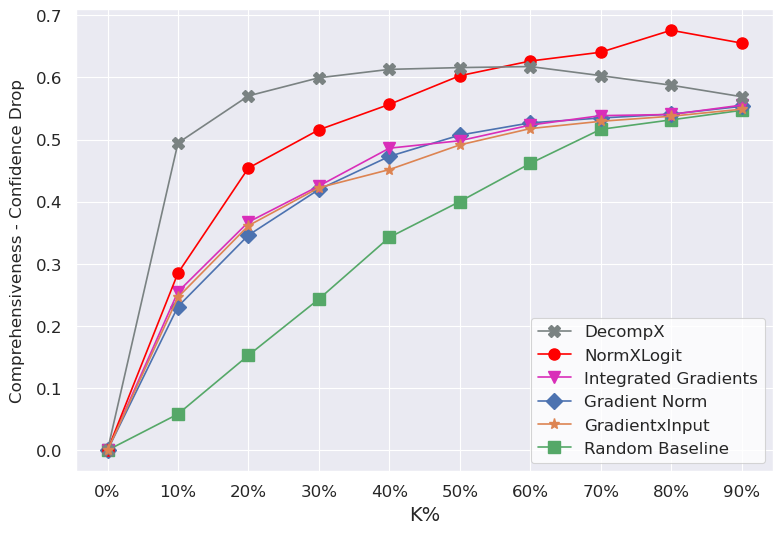

In [14]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 6), facecolor='white')

color0 = '#7a8282'
color2 = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
color3 = (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)
color4 = '#d92eb9'
color5 = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
color6 = '#43b3cc'

metric = "predicted_label_differences"
# metric = "accuracy"
# Create the line plot with markers
plot5 = ax.plot([x for x, y in zipped_results['random_baseline'][metric]], [y for x, y in zipped_results['random_baseline'][metric]], marker='s', markersize=8, linestyle='-', color=color5, label='Random Baseline')
plot2 = ax.plot([x for x, y in zipped_results['saliency'][metric]], [y for x, y in zipped_results['saliency'][metric]], marker='D', markersize=8, linestyle='-', color=color2, label='Gradient Norm')
plot4 = ax.plot([x for x, y in zipped_results['integrated_gradients'][metric]], [y for x, y in zipped_results['integrated_gradients'][metric]], marker='v', markersize=8, linestyle='-', color=color4, label='Integrated Gradients')
plot1 = ax.plot([x for x, y in zipped_results['norm2Xclassifier_reps_12'][metric]], [y for x, y in zipped_results['norm2Xclassifier_reps_12'][metric]], marker='o', markersize=8, linestyle='-', color='red', label='NormXLogit')
plot0 = ax.plot([x for x, y in zipped_results['decompx'][metric]], [y for x, y in zipped_results['decompx'][metric]], marker='X', markersize=8, linestyle='-', color=color0, label='DecompX')
plot3 = ax.plot([x for x, y in zipped_results['InputXGradient'][metric]], [y for x, y in zipped_results['InputXGradient'][metric]], marker='*', markersize=8, linestyle='-', color=color3, label='GradientxInput')

# Manually create the legend to ensure correct order
handles, labels = ax.get_legend_handles_labels()
order = [4, 3, 2, 1, 5, 0]  # Order in which you want the legend to appear
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], facecolor='white', fontsize=12, loc='lower right')

# Add gridlines with custom styling
ax.tick_params(axis='both', which='major', labelsize=12, length=6, width=2)

# Add labels and title
ax.set_xlabel('K%', fontsize=14)
ax.set_ylabel('Comprehensiveness - Confidence Drop', fontsize=12, labelpad=8)

sns.set_style()
sns.set_theme()
sns.set_context("paper")

# fig.savefig("./SST2-BERT-norm2.png", format='png', dpi=80)
fig.savefig("MNLI-BERT-Comp-CD.pdf", format="pdf", bbox_inches="tight", dpi=600)
plt.show()


## Sufficiency

In [ ]:
results_for_plotting = {
    "norm2": {"predicted_label_differences": [], "accuracy": []},
    "classifier_reps": {"predicted_label_differences": [], "accuracy": []},
    "decompx": {"predicted_label_differences": [], "accuracy": []},
    "random_baseline": {"predicted_label_differences": [], "accuracy": []},
    "saliency": {"predicted_label_differences": [], "accuracy": []},
    "InputXGradient": {"predicted_label_differences": [], "accuracy": []},
    "integrated_gradients": {"predicted_label_differences": [], "accuracy": []},
    "norm2Xclassifier_reps_12": {"predicted_label_differences": [], "accuracy": []},
}

layer = diagram_layers[12]
len_test_dataset = len(predicted_labels) # 495 samples

for k in k_list:
    # Special case: norm2 has a fixed layer=0
    avg_diff = np.sum(res_dict[f'norm2_predicted_label_differences_suff_kpercent{k}_layer{0}']) / len_test_dataset
    results_for_plotting["norm2"]["predicted_label_differences"].append(avg_diff)
    results_for_plotting["norm2"]["accuracy"].append(res_dict[f'norm2_accuracy_suff_kpercent{k}_layer{0}'])

    avg_diff = np.sum(res_dict[f'classifier_reps_predicted_label_differences_suff_kpercent{k}_layer{layer}']) / len_test_dataset
    results_for_plotting["classifier_reps"]["predicted_label_differences"].append(avg_diff)
    results_for_plotting["classifier_reps"]["accuracy"].append(res_dict[f'classifier_reps_accuracy_suff_kpercent{k}_layer{layer}'])
    
    # Others without layer
    for method in [
        "decompx",
        "random_baseline",
        "saliency",
        "InputXGradient",
        "integrated_gradients",
        "norm2Xclassifier_reps_12",
    ]:

        avg_diff = np.sum(res_dict[f'{method}_predicted_label_differences_suff_kpercent{k}']) / len_test_dataset
        results_for_plotting[method]["predicted_label_differences"].append(avg_diff)
        results_for_plotting[method]["accuracy"].append(res_dict[f'{method}_accuracy_suff_kpercent{k}'])

percentages = [f"{i}%" for i in range(0, 100, 10)]
zipped_results = {
    method: {
        metric: list(zip(percentages, values))
        for metric, values in metrics.items()
    }
    for method, metrics in results_for_plotting.items()
}


In [17]:
for method in results_for_plotting:
    value = np.sum(results_for_plotting[method]["predicted_label_differences"][1:10]) / 9       # "1:" for 10% and ":10" for 90% 
    print(f'{method} = {value}')

norm2 = 0.3894318334165622
classifier_reps = 0.3726261500161775
decompx = 0.1571585901540429
random_baseline = 0.36235152955368727
saliency = 0.2496197002824902
InputXGradient = 0.24465042919967864
integrated_gradients = 0.22136412185729681
norm2Xclassifier_reps_12 = 0.3807478550548992


In [18]:
for method in results_for_plotting:
    value = np.sum(results_for_plotting[method]["accuracy"][1:10]) / 9       # "1:" for 10% and ":10" for 90% 
    print(f'{method} = {value}')

norm2 = 0.4505050505050505
classifier_reps = 0.45881032547699213
decompx = 0.6655443322109988
random_baseline = 0.49001122334455666
saliency = 0.6098765432098766
InputXGradient = 0.6130190796857463
integrated_gradients = 0.6419753086419753
norm2Xclassifier_reps_12 = 0.4507295173961841


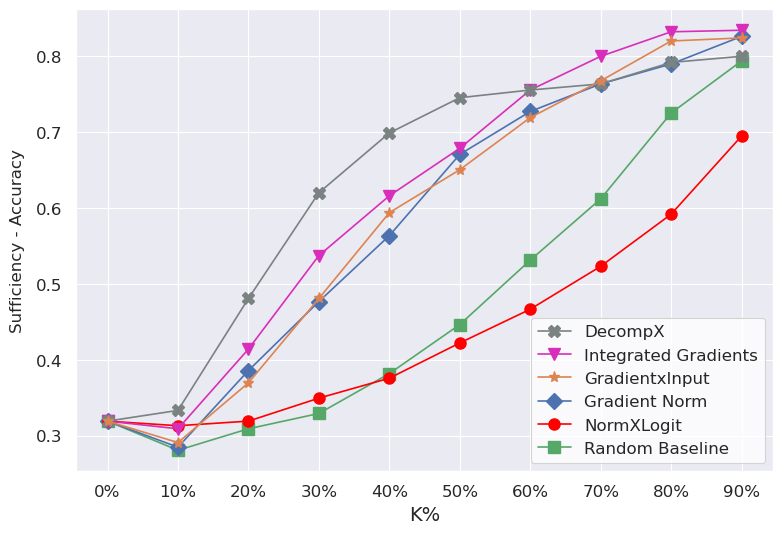

In [26]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 6), facecolor='white')

color0 = '#7a8282'
color2 = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
color3 = (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)
color4 = '#d92eb9'
color5 = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
color6 = '#43b3cc'

# metric = "predicted_label_differences"
metric = "accuracy"
# Create the line plot with markers
plot5 = ax.plot([x for x, y in zipped_results['random_baseline'][metric]], [y for x, y in zipped_results['random_baseline'][metric]], marker='s', markersize=8, linestyle='-', color=color5, label='Random Baseline')
plot2 = ax.plot([x for x, y in zipped_results['saliency'][metric]], [y for x, y in zipped_results['saliency'][metric]], marker='D', markersize=8, linestyle='-', color=color2, label='Gradient Norm')
plot1 = ax.plot([x for x, y in zipped_results['norm2Xclassifier_reps_12'][metric]], [y for x, y in zipped_results['norm2Xclassifier_reps_12'][metric]], marker='o', markersize=8, linestyle='-', color='red', label='NormXLogit')
plot4 = ax.plot([x for x, y in zipped_results['integrated_gradients'][metric]], [y for x, y in zipped_results['integrated_gradients'][metric]], marker='v', markersize=8, linestyle='-', color=color4, label='Integrated Gradients')
plot0 = ax.plot([x for x, y in zipped_results['decompx'][metric]], [y for x, y in zipped_results['decompx'][metric]], marker='X', markersize=8, linestyle='-', color=color0, label='DecompX')
plot3 = ax.plot([x for x, y in zipped_results['InputXGradient'][metric]], [y for x, y in zipped_results['InputXGradient'][metric]], marker='*', markersize=8, linestyle='-', color=color3, label='GradientxInput')

# Manually create the legend to ensure correct order
handles, labels = ax.get_legend_handles_labels()
order = [4, 3, 5, 1, 2, 0]  # Order in which you want the legend to appear
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], facecolor='white', fontsize=12, loc='lower right')

# Add gridlines with custom styling
ax.tick_params(axis='both', which='major', labelsize=12, length=6, width=2)

# Add labels and title
ax.set_xlabel('K%', fontsize=14)
ax.set_ylabel('Sufficiency - Accuracy', fontsize=12, labelpad=8)

sns.set_style()
sns.set_theme()
sns.set_context("paper")

# fig.savefig("./SST2-BERT-norm2.png", format='png', dpi=80)
fig.savefig("MNLI-BERT-Suff-Acc.pdf", format="pdf", bbox_inches="tight", dpi=600)
plt.show()
